# Preliminary

In [17]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

from importlib import reload

In [11]:
import fca_interp as fcai

# Mango DataSet

In [13]:
mango_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'mango.csv'), index_col=0)
print(mango_ds.shape)
mango_ds.head()

(8, 5)


,color,firm,smooth,form,fruit
title,,,,,
apple,yellow,False,True,round,True
grapefruit,yellow,False,False,round,True
kiwi,green,False,False,oval,True
plum,blue,False,True,oval,True
toy cube,green,True,True,cubic,False


In [14]:
mango_bin_ds = mango_ds.copy()
for f in mango_bin_ds.columns:
    if mango_bin_ds[f].nunique()>2:
        for v in mango_bin_ds[f].unique():
            mango_bin_ds[f"{f}__{v}"] = mango_bin_ds[f]==v
        mango_bin_ds = mango_bin_ds.drop(f,1)
print(mango_bin_ds.shape)
mango_bin_ds.head()

(8, 10)


,firm,smooth,fruit,color__yellow,color__green,color__blue,color__white,form__round,form__oval,form__cubic
title,,,,,,,,,,
apple,False,True,True,True,False,False,False,True,False,False
grapefruit,False,False,True,True,False,False,False,True,False,False
kiwi,False,False,True,False,True,False,False,False,True,False
plum,False,True,True,False,False,True,False,False,True,False
toy cube,True,True,False,False,True,False,False,False,False,True


In [30]:
y_feat = 'fruit'
s = mango_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)
y_train = mango_ds[y_feat].astype(int)

train_pool = Pool(mango_ds.drop(y_feat,1), y_train, cat_features=cat_feats)
bb = CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds = bb.predict(train_pool)
train_preds_proba = bb.predict_proba(train_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(),  'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train'])
metrics_ds

,metrics,train
0,accuracy_score,0.875000
1,precision_score,0.833333
2,recall_score,1.000000
3,y_mean,0.625000


In [45]:
%%time
cntx = fcai.Context(mango_bin_ds.drop(y_feat,1),y_true=y_train, y_pred=train_preds)
fm = fcai.FormalManager(cntx, ds_obj=None, task_type='binary classification')
fm.construct_concepts(use_tqdm=False)
fm.construct_lattice(use_tqdm=False)

CPU times: user 62 ms, sys: 432 µs, total: 62.4 ms
Wall time: 60.4 ms


/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [46]:
fig = fm.get_plotly_fig(level_sort='mean', sort_by='y_true',
                        y_precision=2, title='Mango Dataset Concept Lattice', cbar_title='Mean fruit prediction',
                        color_by='y_pred',)

In [47]:
fig.show()

In [48]:
fm._concepts

{Concept 0
 extent (len: 8): apple, grapefruit, kiwi, plum, toy cube, egg, tennis ball, mango
 intent (len: 0): emptyset
 lower neighbours (len: 5): 1,2,3,4,5
 upper neighbours (len: 0): emptyset
 level: 0
 mean y_true: 0.625
 mean y_pred: 0.75
 metrics: {'accuracy': 0.88, 'precision': 0.83, 'recall': 1.0, 'neg_precision': 1.0, 'neg_recall': 0.67},
 Concept 10
 extent (len: 2): toy cube, mango
 intent (len: 2): smooth, color__green
 lower neighbours (len: 2): 13,15
 upper neighbours (len: 2): 2,5
 level: 2
 mean y_true: 0.5
 mean y_pred: 0.5
 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'neg_precision': 1.0, 'neg_recall': 1.0},
 Concept 11
 extent (len: 1): tennis ball
 intent (len: 2): color__white, form__round
 new extent (len: 1): tennis ball
 lower neighbours (len: 1): 17
 upper neighbours (len: 2): 3,4
 level: 2
 mean y_true: 0.0
 mean y_pred: 1.0
 metrics: {'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'neg_precision': 0.0, 'neg_recall': 0.0},
 Concept 12
 exte

# Bank DataSet

In [2]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats],
                                                    bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]),
                                                   random_state=42)

train_pool = cb.Pool(X_train, y_train, cat_features=cat_feats)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_feats)
bb = cb.CatBoostClassifier(random_seed=42)
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

,metrics,train,test
0,accuracy_score,0.937758,0.905393
1,precision_score,0.838828,0.600000
2,recall_score,0.578283,0.432000
3,y_mean,0.116814,0.110522


# Задача

Найти импликации, гипотезы и ассоциативные правила, которые отражают зависимость целевой переменной $Y$ от конкретных значений признаков и исходных данных $X$.

Для лучшей интерпретабельности желательно использовать как можно меньше признаков и их значений. Для этого нужно отобрать наиболее важные признаки и их наиболее влиятельные значения. Как это сделать? Через Shap.

In [4]:
sv = bb.get_feature_importance(test_pool, type='ShapValues')
expected_value = sv[0,-1]
sv_ds = pd.DataFrame(sv[:,:-1], columns=test_pool.get_feature_names())
sv_ds.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,age,balance,day,duration,campaign,pdays,previous
0,-0.031291,-0.028272,0.035948,-0.267942,0.101734,-0.268115,0.287815,-0.323185,-0.132049,-0.030460,-0.318450,-0.020844,-1.178477,-0.127363,0.049373,-0.018233
1,0.127565,0.018116,0.079303,-0.008569,0.096851,0.031259,0.187173,0.168337,0.890014,-0.044830,0.208614,-0.046283,1.976521,0.021740,0.050712,0.346256
2,-0.030689,-0.021500,0.028779,0.006304,0.096207,0.052130,0.282196,-0.105999,-0.113547,-0.046154,0.107670,0.009493,-0.678837,0.034704,0.059806,-0.013104
3,0.031418,-0.033332,0.083075,0.001851,-0.065374,0.046528,-0.630254,-0.083773,-0.128123,-0.081089,-0.146013,0.002586,0.676073,-0.356123,0.025053,-0.038261
4,0.007788,0.058849,0.010468,-0.001448,0.106346,0.037828,0.319354,0.229482,-0.117150,-0.034576,0.018484,-0.047470,0.977713,0.028636,0.043395,-0.037927


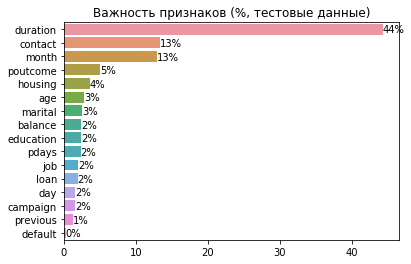

In [5]:
s = sv_ds.abs().median(0).sort_values(ascending=False)
s = s/s.sum()*100
sns.barplot(x=s.values, y=s.index)
for idx, t in enumerate(s.iteritems()):
    plt.text(t[1], idx+0.25, f"{t[1]:.0f}%")
plt.title('Важность признаков (%, тестовые данные)')
plt.show()

In [6]:
bin_funcs = {}

Первые 3 признака сильно лидируют по важности (duration, contact, month). Рассмотрим их более детально.

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


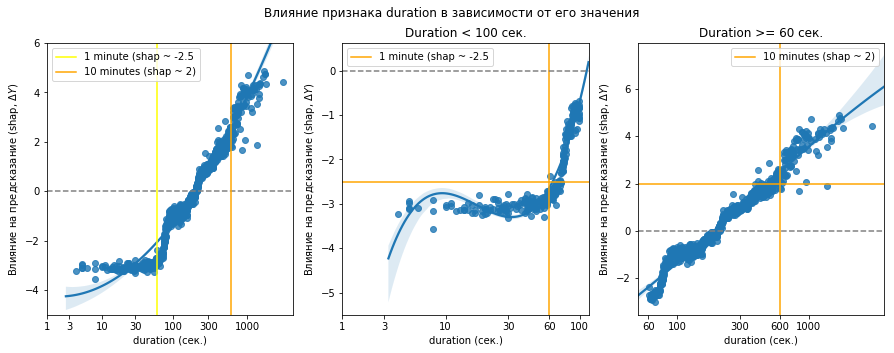

In [7]:
f = 'duration'
cds = pd.DataFrame()
cds[f] = np.log1p(X_test[f])
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(131)
sns.regplot(x='duration', y=f+'_shap', data=cds, order=2)
xticks = np.array([1, 3,10,30,100,300,1000])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline(np.log1p(60), color='yellow', label='1 minute (shap ~ -2.5')
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.legend()
plt.xticks(np.log1p(xticks), xticks)
plt.ylim((-5,6))
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')

plt.subplot(132)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]<np.log1p(100)], order=3)
xticks = np.array([1, 3,10,30,60,100])
plt.axvline(np.log1p(60), color='orange', label='1 minute (shap ~ -2.5')
plt.axhline(-2.5, color='orange')
plt.legend()
plt.axhline(0, linestyle='--', color='grey')
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration < 100 сек.')

plt.xticks(np.log1p(xticks), xticks)

plt.subplot(133)
sns.regplot(x='duration', y=f+'_shap', data=cds[cds[f]>=np.log1p(60)], order=3)
xticks = np.array([60, 100, 300, 600, 1000])
plt.xticks(np.log1p(xticks), xticks)
plt.axvline(np.log1p(600), color='orange', label='10 minutes (shap ~ 2)')
plt.axhline(2, color='orange')
plt.axhline(0, linestyle='--', color='grey')
plt.legend()
plt.xlabel('duration (сек.)')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Duration >= 60 сек.')


plt.suptitle('Влияние признака duration в зависимости от его значения')
plt.show()

In [8]:
def binf_duration(x):
    b = pd.Series()
    b['<1m'] = x<60
    b['>=1m'] = x>=60
    b['>=10m'] = x>=600
    return b.astype(int)

In [9]:
bin_funcs['duration'] = binf_duration

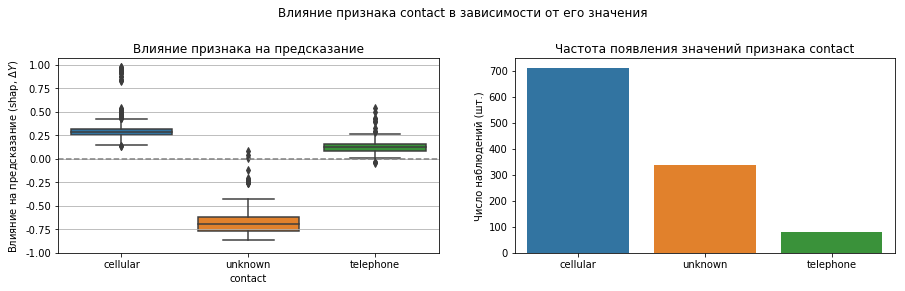

In [10]:
f = 'contact'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,4))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds)
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,1.1, 0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle('Влияние признака contact в зависимости от его значения')
plt.show()

In [11]:
def binf_contact(x):
    b = pd.Series()
    for v in ['cellular','unknown']:
        b[v] = x==v
    return b.astype(int)

In [12]:
bin_funcs['contact'] = binf_contact

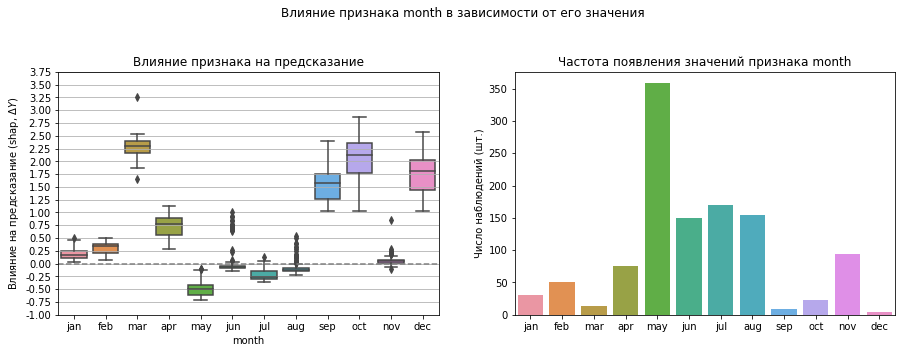

In [13]:
f = 'month'
cds = pd.DataFrame()
cds[f] = X_test[f]
cds[f+'_shap'] = sv_ds[f].values

plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x=f, y=f+'_shap', data=cds, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.axhline(0, linestyle='--', color='grey')
plt.ylabel(r'Влияние на предсказание (shap, $\Delta Y$)')
plt.title('Влияние признака на предсказание')
yticks = np.arange(-1,4,0.25)
plt.yticks(yticks, [f"{x:.2f}" for x in yticks])
plt.grid(axis='y')

plt.subplot(122)
s_ = cds[f].value_counts()
#s_ = s_/s_.sum()*100
s_ = s_.reindex(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
sns.barplot(x=s_.index, y=s_.values)
plt.title(f'Частота появления значений признака {f}')
plt.ylabel('Число наблюдений (шт.)')

plt.subplots_adjust(top=0.8)
plt.suptitle(f'Влияние признака {f} в зависимости от его значения')
plt.show()

In [14]:
def binf_month(x):
    b = pd.Series()
    for v in ['feb', 'mar', 'apr', 'may', 'sep','oct','dec']:
        b[v] = x==v
    return b.astype(int)

In [15]:
bin_funcs['month'] = binf_month

Данные ужасны, но продолжим работу

In [24]:
bin_ds = []
for f in tqdm_notebook(s[:2].index):
    cds = pd.concat([bin_funcs[f](x) for x in X_test[f]],1).T
    cds.columns = [f"{f}_{x}" for x in cds.columns]
    bin_ds.append(cds)
bin_ds = pd.concat(bin_ds,1)
bin_ds.index = X_test.index
print(bin_ds.shape)
bin_ds.head()


(1131, 5)


,duration_<1m,duration_>=1m,duration_>=10m,contact_cellular,contact_unknown
2398,0,1,0,1,0
800,0,1,0,1,0
2288,0,1,0,1,0
2344,0,1,0,0,1
3615,0,1,0,1,0


In [25]:
import fca_interp as fcai

In [26]:
fcai = reload(fcai)

In [27]:
bin_ds = bin_ds.astype(bool)

In [28]:
%%time
cntx = fcai.Context(bin_ds,y_true=y_test, y_pred=test_preds)
fm = fcai.FormalManager(cntx, ds_obj=None, task_type='binary classification')
fm.construct_concepts(use_tqdm=False)
fm.construct_lattice(use_tqdm=False)

CPU times: user 83.1 ms, sys: 0 ns, total: 83.1 ms
Wall time: 83.2 ms


/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples.



In [29]:
fig = fm.get_plotly_fig(level_sort='all', sort_by='y_true',
                        y_precision=2, title='Bank Dataset Concept Lattice', cbar_title='Y rate',
                        color_by='accuracy',)

In [30]:
fig.show()

# Очищаем решётку